In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.under_sampling import NearMiss
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing
import statsmodels.api as sm
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, concatenate
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_excel("./energy_demand.xlsx")
df.head()

,Date,Hour,load,T
0,2012-01-01,0,2872.0,30.666667
1,2012-01-01,1,2698.0,32.000000
2,2012-01-01,2,2558.0,32.666667
3,2012-01-01,3,2444.0,30.000000
4,2012-01-01,4,2402.0,31.000000


In [4]:
df.tail()

,Date,Hour,load,T
26300,2014-12-31,20,4012.0,18.000000
26301,2014-12-31,21,3856.0,16.666667
26302,2014-12-31,22,3671.0,17.000000
26303,2014-12-31,23,3499.0,15.333333
26304,2014-12-31,24,3345.0,15.333333


In [5]:
len(df.columns)

4

In [6]:
df.columns
df.dtypes

Date    datetime64[ns]
Hour             int64
load           float64
T              float64
dtype: object

In [7]:
df.shape

(26305, 4)

In [8]:
df.size

105220

In [9]:
df.min()

Date    2012-01-01 00:00:00
Hour                      0
load                 1979.0
T                -13.666667
dtype: object

In [10]:
df.max()

Date    2014-12-31 00:00:00
Hour                     24
load                 5224.0
T                      95.0
dtype: object

In [11]:
df.describe()

,Date,Hour,load,T
count,26305,26305.000000,26305.000000,26305.000000
mean,2013-07-01 11:30:01.710701312,12.499525,3303.752785,47.764988
min,2012-01-01 00:00:00,0.000000,1979.000000,-13.666667
25%,2012-09-30 00:00:00,6.000000,2867.000000,32.666667
50%,2013-07-01 00:00:00,12.000000,3364.000000,48.333333
75%,2014-04-01 00:00:00,18.000000,3690.000000,63.666667
max,2014-12-31 00:00:00,24.000000,5224.000000,95.000000
std,NaN,6.922616,564.574798,19.338062


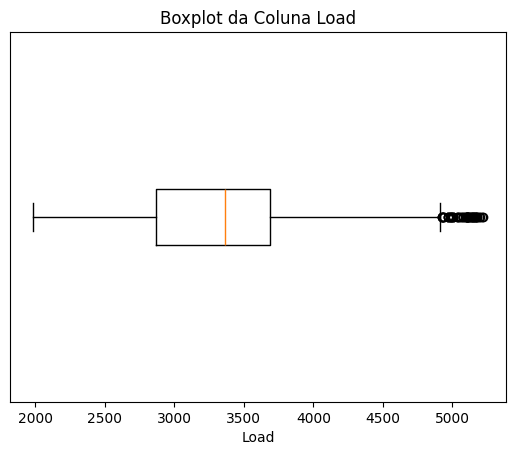

In [12]:
plt.boxplot(df['load'], vert=False)

# Adiciona rótulos e título
plt.xlabel('Load')
plt.title('Boxplot da Coluna Load')
plt.yticks([])

# Mostra o boxplot
plt.show()

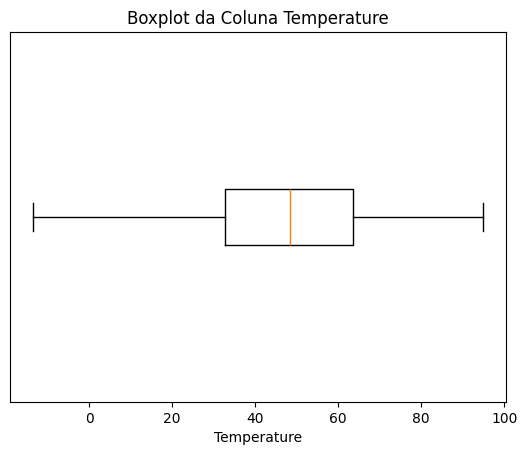

In [13]:
plt.boxplot(df['T'], vert=False)

# Adiciona rótulos e título
plt.xlabel('Temperature')
plt.title('Boxplot da Coluna Temperature')
plt.yticks([])

# Mostra o boxplot
plt.show()

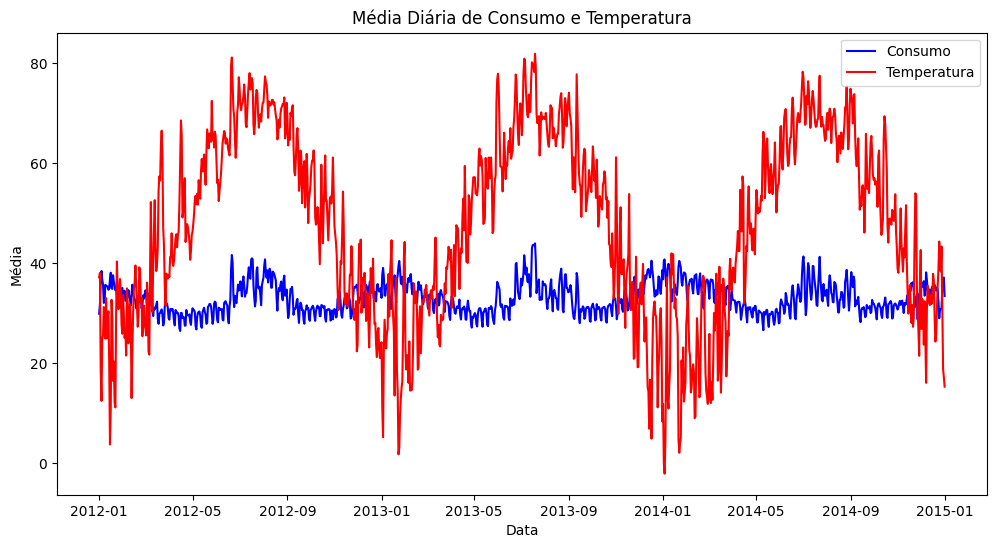

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')

# Criar a coluna 'DateTime' combinando 'Date' e 'Hour'
df['DateTime'] = df['Date'] + df['Hour']

# Remover 'Date' e 'Hour' se necessário
df.drop(['Date', 'Hour'], axis=1, inplace=True)

# Configurar 'DateTime' como índice
df.set_index('DateTime', inplace=True)
# Agrupar por dia e calcular a média
daily_data = df.resample('D').mean()
daily_data['load'] = daily_data['load'] / 100

# Plotar o gráfico de dupla entrada
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_data.index, y=daily_data['load'], label='Consumo', color='blue')
sns.lineplot(x=daily_data.index, y=daily_data['T'], label='Temperatura', color='red')

plt.title('Média Diária de Consumo e Temperatura')
plt.xlabel('Data')
plt.ylabel('Média')
plt.legend()
plt.show()


In [15]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


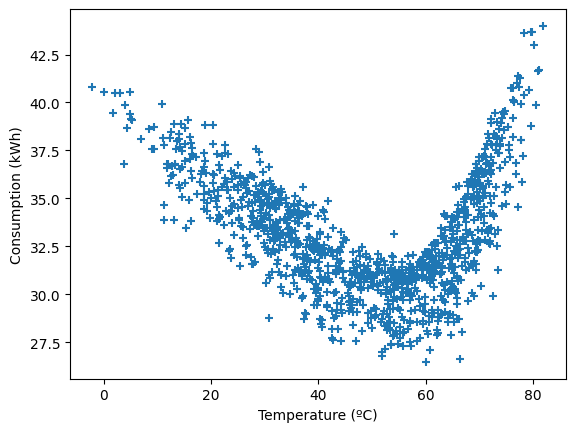

In [16]:
plt.scatter(daily_data['T'], daily_data['load'], marker='+')

plt.xlabel('Temperature (ºC)')
plt.ylabel('Consumption (kWh)')
plt.show()

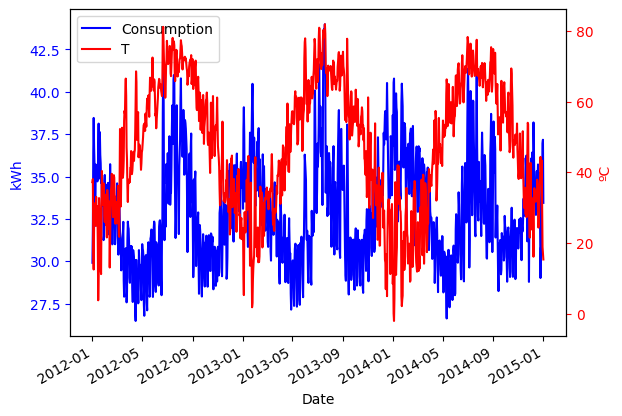

In [17]:
fig, ax1 = plt.subplots()

ax1.plot(daily_data.index, daily_data['load'], 'b', label='Consumption')
ax1.set_xlabel('Date')
ax1.set_ylabel('kWh', color='b')
ax1.tick_params('y', colors='b')

fig.autofmt_xdate()

ax2 = ax1.twinx()

ax2.plot(daily_data.index, daily_data['T'], 'r', label='T')
ax2.set_ylabel('ºC', color='r')
ax2.tick_params('y', colors='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.show()


In [18]:
df1=df
daily_data = df1.resample('24h').mean()
daily_data.head()


,load,T
DateTime,,
2012-01-01,2991.458333,37.208333
2012-01-02,3188.791667,38.083333
2012-01-03,3645.375000,18.291667
2012-01-04,3846.041667,12.486111
2012-01-05,3672.458333,25.000000


In [19]:
df.isna().sum()


load    0
T       0
dtype: int64

In [20]:
df.isnull().sum()

load    0
T       0
dtype: int64

In [21]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


In [22]:
load_series = df['load']

# Aplicar o teste ADF
result = adfuller(load_series)

# Exibir os resultados
print('ADF Statistic:', result[0])
print(f'p-value: {result[1]:.3e}')  # Formatando o p-value para notação científica com 3 casas decimais
print('Critical Values:', result[4])
#p-value mais baixo que 0.05 significa que se rejeita a hipotese nula, ou seja, admite-se que a série é estacionária

ADF Statistic: -10.406281746483792
p-value: 1.853e-18
Critical Values: {'1%': -3.430599093104556, '5%': -2.861650091842415, '10%': -2.566828598628419}


In [23]:
"""#df['hourofday'] = df.index.hour
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week
df['days_in_month'] = df.index.days_in_month
df['isWeekend'] = df.index.weekday // 5
df['isWeekend'] = df['isWeekend'].map({0: 'No', 1: 'Yes'})
df['dayoftheweek'] = df.index.dayofweek"""

"#df['hourofday'] = df.index.hour\ndf['quarter'] = df.index.quarter\ndf['month'] = df.index.month\ndf['year'] = df.index.year\ndf['dayofyear'] = df.index.dayofyear\ndf['dayofmonth'] = df.index.day\ndf['weekofyear'] = df.index.isocalendar().week\ndf['days_in_month'] = df.index.days_in_month\ndf['isWeekend'] = df.index.weekday // 5\ndf['isWeekend'] = df['isWeekend'].map({0: 'No', 1: 'Yes'})\ndf['dayoftheweek'] = df.index.dayofweek"

In [24]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


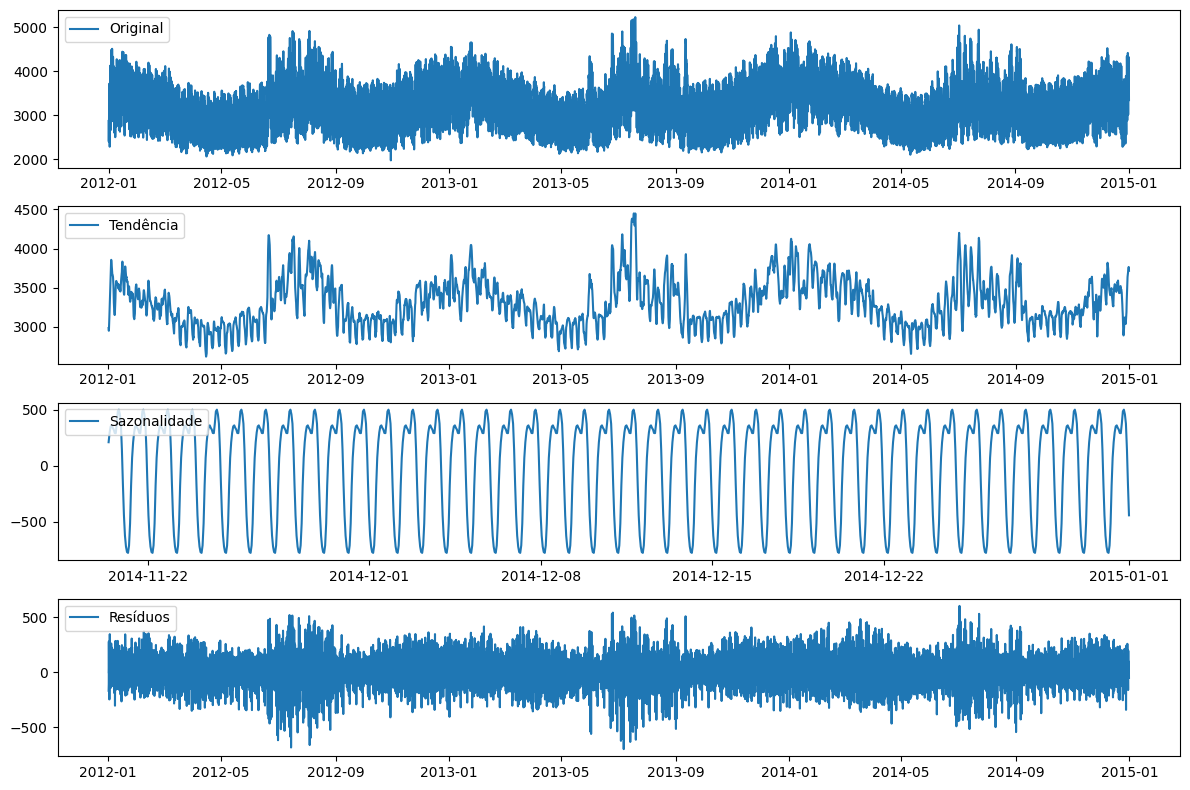

In [55]:

# Supondo que 'df' seja seu DataFrame com uma coluna chamada 'load'
load_series = df['load']

# Realizar a decomposição
result = seasonal_decompose(load_series, model='additive', period=24)  # O período aqui é assumido como 24 para dados horários

# Extrair as componentes
trend = result.trend
seasonal = result.seasonal
residuals = result.resid
last_1000_seasonal = seasonal.tail(1000)
# Plotar as componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(load_series, label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')


plt.subplot(4, 1, 3)
plt.plot(last_1000_seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)    
plt.plot(residuals, label='Resíduos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


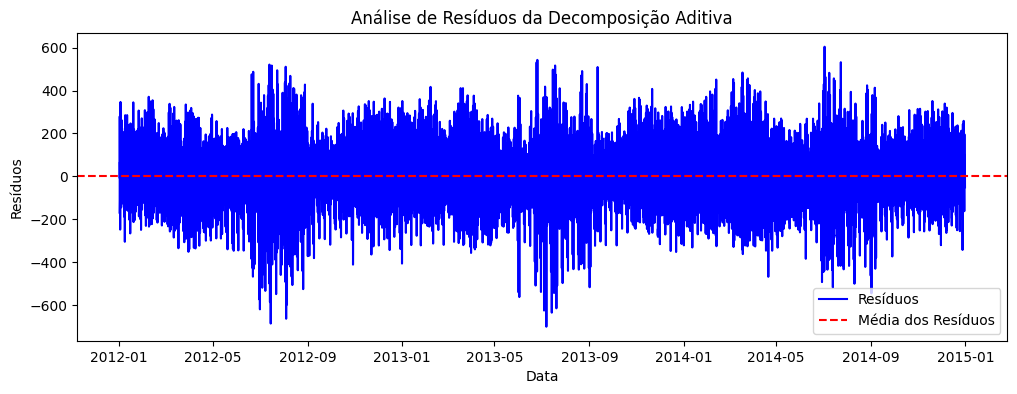

<Figure size 1200x600 with 0 Axes>

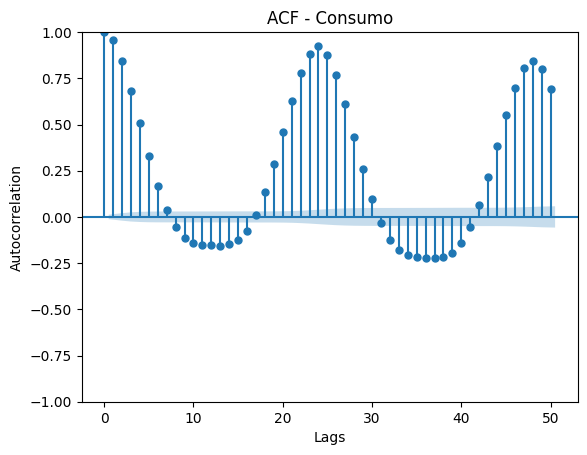

<Figure size 1200x600 with 0 Axes>

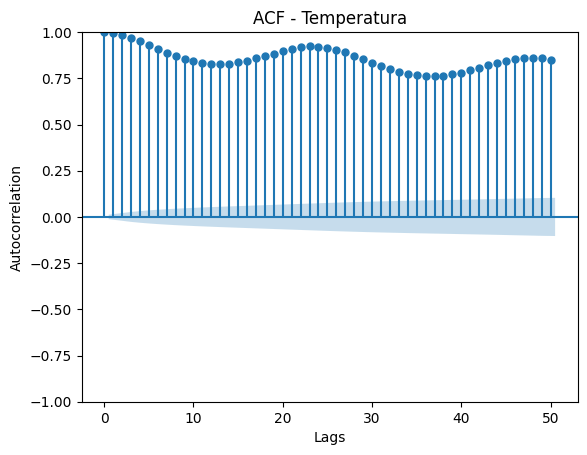

In [26]:

consumo_series = df['load']
temperatura_series = df['T']

plt.figure(figsize=(12, 6))
plot_acf(consumo_series, lags=50, title='ACF - Consumo')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(temperatura_series, lags=50, title='ACF - Temperatura')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()
#correlaçao existe até 10 dias


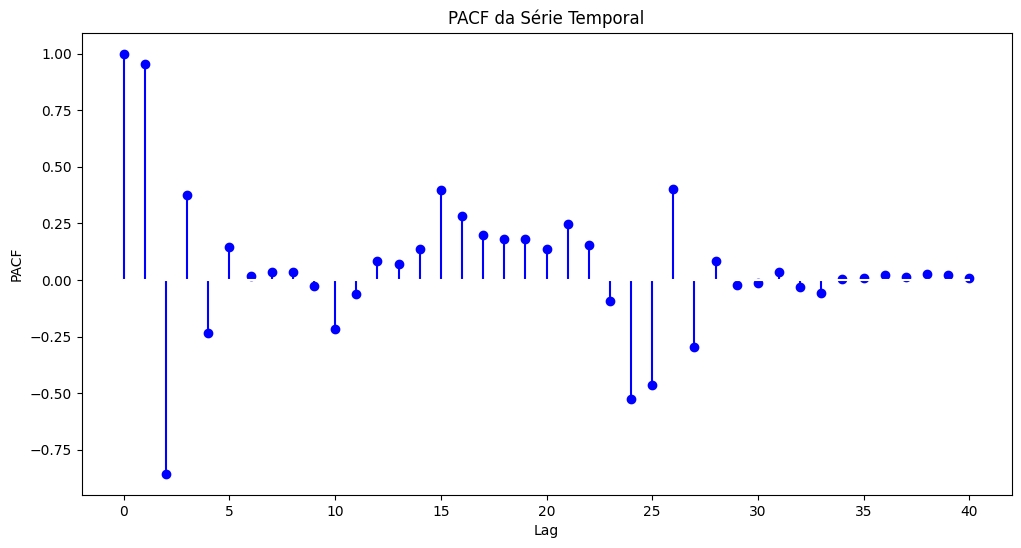

In [27]:
pacf_values, pacf_conf_int = sm.tsa.pacf(df['load'], nlags=40, alpha=0.05)

# Plotar a PACF
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values, linefmt='b-', markerfmt='bo', basefmt='w-')
plt.title('PACF da Série Temporal')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [28]:
# Criar cópias atrasadas das séries temporais
lag_consumo = 1  # Defina o lag desejado
lag_temperatura = 0  # Pode ajustar conforme necessário

consumo_shifted = consumo_series.shift(lag_consumo)
temperatura_shifted = temperatura_series.shift(lag_temperatura)

# Calcular a correlação entre as séries temporais atrasadas
correlation = consumo_shifted.corr(temperatura_shifted)

print(f"Correlação entre Consumo (lag={lag_consumo}) e Temperatura (lag={lag_temperatura}): {correlation}")


Correlação entre Consumo (lag=1) e Temperatura (lag=0): 0.08164031232672768


In [29]:
variavel = 10
resultado = variavel * 2
print(resultado)
d = 0
D = 0
s = 24

def evaluate_sarima(order, seasonal_order, data):
    try:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        aic = results.aic
        return aic
    except:
        return float('inf')  # Return a large value for combinations that fail

def grid_search_sarima(data, p_values, d, q_values, P_values, D, Q_values, s):
    best_aic = float('inf')
    best_params = None

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(p_values,  q_values, P_values, Q_values))

    for param_set in param_combinations:
        order = (param_set[0], d, param_set[1])
        seasonal_order = (param_set[2], D, param_set[3], s)
        print(param_set)
        aic = evaluate_sarima(order, seasonal_order, data)

        if aic < best_aic:
            best_aic = aic
            best_params = param_set

    return best_params, best_aic

# Example usage:
# Define the ranges for your parameters
p_values = range(1, 5)
q_values = range(1, 5)
P_values = range(1, 5)
Q_values = range(1, 5)

# Perform grid search
best_params, best_aic = grid_search_sarima(df['load'], p_values, d, q_values, P_values, D, Q_values, s)

print("Best Parameters:", best_params)
print("Best AIC:", best_aic)







'\n\nvariavel = 10\nresultado = variavel * 2\nprint(resultado)\nd = 0\nD = 0\ns = 24\n\ndef evaluate_sarima(order, seasonal_order, data):\n    try:\n        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)\n        results = model.fit(disp=False)\n        aic = results.aic\n        return aic\n    except:\n        return float(\'inf\')  # Return a large value for combinations that fail\n\ndef grid_search_sarima(data, p_values, d, q_values, P_values, D, Q_values, s):\n    best_aic = float(\'inf\')\n    best_params = None\n\n    # Generate all combinations of parameters\n    param_combinations = list(itertools.product(p_values,  q_values, P_values, Q_values))\n\n    for param_set in param_combinations:\n        order = (param_set[0], d, param_set[1])\n        seasonal_order = (param_set[2], D, param_set[3], s)\n        print(param_set)\n        aic = evaluate_sarima(order, seasonal_order, data)\n\n        if aic < best_aic:\n            best_aic = aic\n            best_p

In [30]:
# Definir os melhores parâmetros obtidos
order = (2, 0, 3)
seasonal_order = (2, 0, 2, 24)
model = SARIMAX(df['load'], order=(3, 0, 3), seasonal_order=(2,0,3,24))
model_fit = model.fit()
print(model_fit.summary())
residuals = model_fit.resid[1:]

residuals_test = acorr_ljungbox(residuals, np.arange(1, 11, 1))

residuals_test['lb_pvalue'].describe()

df_load = df['load']
train_size = len(df_load) - 168
train, test = df_load[:train_size], df[train_size:]
# Criar e ajustar o modelo SARIMA
model = SARIMAX(df['load'], order=order, seasonal_order=seasonal_order)
results = model.fit()


forecast_steps = 168  
forecast = results.get_forecast(steps=forecast_steps)
confidence_intervals= forecast.conf_int()
mse_sarima = ((test - forecast.predicted_mean) ** 2).mean()

mae_sarima = mean_absolute_error(test, forecast)
mse_sarima = mean_squared_error(test, forecast)
rmse_sarima = mean_squared_error(test, forecast, squared=False) 

print(f'Mean Absolute Error (MAE) - SARIMA: {mae_sarima}')
print(f'Mean Squared Error (MSE) - SARIMA: {mse_sarima}')
print(f'Root Mean Squared Error (RMSE) - SARIMA: {rmse_sarima}')


KeyboardInterrupt: 

In [ ]:
predicted_values = forecast.predicted_mean
plt.plot(test.index, test["load"], label='Actual Data')
plt.plot(test.index, predicted_values, label='Predicted Data')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=0.1, label='Confidence Intervals')
plt.legend()
plt.show()

'predicted_values = forecast.predicted_mean\nplt.plot(test.index, test["load"], label=\'Actual Data\')\nplt.plot(test.index, predicted_values, label=\'Predicted Data\')\nplt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color=\'k\', alpha=0.1, label=\'Confidence Intervals\')\nplt.legend()\nplt.show()'

In [ ]:
p, d, q =2, 0, 2
P, D, Q, s = 3, 0, 2, 24

exog_variable = df['T']

sarimax_model_exog = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), exog=exog_variable[:train_size])
sarimax_result_exog = sarimax_model_exog.fit(disp=False,method='powell')
forecast_steps = 168

# Make predictions on the test set with exogenous variable
exog_forecast = exog_variable[train_size:train_size+forecast_steps]

forecast = results.get_forecast(steps=forecast_steps, exog=exog_forecast)
confidence_intervals = forecast.conf_int()

predicted_values_exog = forecast.predicted_mean
mae_sarimaX = mean_absolute_error(test, forecast)
mse_sarimaX = mean_squared_error(test, forecast)
rmse_sarimaX = mean_squared_error(test, forecast, squared=False) 

print(f'Mean Absolute Error (MAE) - SARIMAX: {mae_sarimaX}')
print(f'Mean Squared Error (MSE) - SARIMAX: {mse_sarimaX}')
print(f'Root Mean Squared Error (RMSE) - SARIMAX: {rmse_sarimaX}')

MemoryError: Unable to allocate 1.06 GiB for an array with shape (74, 74, 26103) and data type float64

: 

In [ ]:
mse_sarimax_exog = ((test - predicted_values_exog) ** 2).mean()
print(f'Mean Squared Error (SARIMAX com Exog): {mse_sarimax_exog}')


In [ ]:
plt.plot(test.index, test["load"], label='Actual Data')
plt.plot(test.index, predicted_values_exog, label='Predicted Data')
plt.fill_between(test.index, confidence_intervals_exog.iloc[:, 0], confidence_intervals_exog.iloc[:, 1], color='k', alpha=0.1, label='Confidence Intervals')
plt.legend()
plt.show()

'plt.plot(test.index, test["load"], label=\'Actual Data\')\nplt.plot(test.index, predicted_values_exog, label=\'Predicted Data\')\nplt.fill_between(test.index, confidence_intervals_exog.iloc[:, 0], confidence_intervals_exog.iloc[:, 1], color=\'k\', alpha=0.1, label=\'Confidence Intervals\')\nplt.legend()\nplt.show()'

# Machine Learning


In [71]:

def create_lagged_features(data, window_size, horizon=1):
   
      
    X, y = [], []
    for i in range(0, len(data) - window_size - horizon + 1):
        window = data.iloc[i:i + window_size].values  
        target = data.iloc[i + window_size + horizon - 1]  

        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)


In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



window_size = 5

X, y = create_lagged_features(df['load'], window_size)




split_ratio = 0.8
split_index = int(split_ratio * len(df))

print(X.shape)
print(y.shape)

X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]



(26300, 5)
(26300,)


In [76]:
model_lr_single = LinearRegression()
model_lr_single.fit(X_train, y_train)

predictions_single_lr = model_lr_single.predict(X_test)
mse_single_lr = mean_squared_error(y_test, predictions_single_lr)
print(f'Mean Squared Error (Single Step - Regressão Linear): {mse_single_lr}')
mae_lr_single = mean_absolute_error(y_test, predictions_single_lr)
mse_lr_single = mean_squared_error(y_test, predictions_single_lr)
rmse_lr_single = mean_squared_error(y_test, predictions_single_lr, squared=False) 

print(f'Mean Absolute Error (MAE) - Regressão Linear: {mae_lr_single}')
print(f'Mean Squared Error (MSE) - Regressão Linear: {mse_lr_single}')
print(f'Root Mean Squared Error (RMSE) - Regressão Linear: {rmse_lr_single}')

model_xgb_single = XGBRegressor()
model_xgb_single.fit(X_train, y_train)

predictions_single_xgb = model_xgb_single.predict(X_test)

mse_single_xgb = mean_squared_error(y_test, predictions_single_xgb)
print(f'Mean Squared Error (Single Step - XGBoost): {mse_single_xgb}')

mae_xgb_single = mean_absolute_error(y_test, predictions_single_xgb)
mse_xgb_single = mean_squared_error(y_test, predictions_single_xgb)
rmse_xgb_single = mean_squared_error(y_test, predictions_single_xgb, squared=False) 

print(f'Mean Absolute Error (MAE) - XGBoost: {mae_xgb_single}')
print(f'Mean Squared Error (MSE) - XGBoost: {mse_xgb_single}')
print(f'Root Mean Squared Error (RMSE) - XGBoost: {rmse_xgb_single}')

from sklearn.ensemble import GradientBoostingRegressor



model_gboost_single = GradientBoostingRegressor()
model_gboost_single.fit(X_train, y_train)

predictions_single_gboost = model_gboost_single.predict(X_test)

mse_single_gboost = mean_squared_error(y_test, predictions_single_gboost)
print(f'Mean Squared Error (Single Step - Gradient Boosting): {mse_single_gboost}')

mae_gboost_single = mean_absolute_error(y_test, predictions_single_gboost)
mse_gboost_single = mean_squared_error(y_test, predictions_single_gboost)
rmse_gboost_single = mean_squared_error(y_test, predictions_single_gboost, squared=False) 

print(f'Mean Absolute Error (MAE) - GBoost: {mae_gboost_single}')
print(f'Mean Squared Error (MSE) - GBoost: {mse_gboost_single}')
print(f'Root Mean Squared Error (RMSE) - GBoost: {rmse_gboost_single}')

from sklearn.ensemble import RandomForestRegressor


model_rf_single = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_single.fit(X_train, y_train)

predictions_single_rf = model_rf_single.predict(X_test)

mse_single_rf = mean_squared_error(y_test, predictions_single_rf)
print(f'Mean Squared Error (Single Step - Random Forest): {mse_single_rf}')

mae_rf_single = mean_absolute_error(y_test, predictions_single_rf)
mse_rf_single = mean_squared_error(y_test, predictions_single_rf)
rmse_rf_single = mean_squared_error(y_test, predictions_single_rf, squared=False) 

print(f'Mean Absolute Error (MAE) - Random Forest: {mae_rf_single}')
print(f'Mean Squared Error (MSE) - Random Forest: {mse_rf_single}')
print(f'Root Mean Squared Error (RMSE) - Random Forest: {rmse_rf_single}')

from sklearn.neural_network import MLPRegressor
import tensorflow as tf

model_nn_single = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
model_nn_single.fit(X_train, y_train)

predictions_single_nn = model_nn_single.predict(X_test)

mse_single_nn = mean_squared_error(y_test, predictions_single_nn)
print(f'Mean Squared Error (Single Step - Neural Network): {mse_single_nn}')

mae_nn_single = mean_absolute_error(y_test, predictions_single_nn)
mse_nn_single = mean_squared_error(y_test, predictions_single_nn)
rmse_nn_single = mean_squared_error(y_test, predictions_single_nn, squared=False) 

print(f'Mean Absolute Error (MAE) - NN: {mae_nn_single}')
print(f'Mean Squared Error (MSE) - NN: {mse_nn_single}')
print(f'Root Mean Squared Error (RMSE) - NN: {rmse_nn_single}')


"""model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  
])
scaler= MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred_multi_NN = model.predict(X_test).flatten()

mse_multi_NN = mean_squared_error(y_test, y_pred_multi_NN)
print(f'Mean Squared Error on Multi Step Neural Network: {mse_multi_NN}')"""


Mean Squared Error (Single Step - Regressão Linear): 5114.658450547713
Mean Absolute Error (MAE) - Regressão Linear: 50.87456120048641
Mean Squared Error (MSE) - Regressão Linear: 5114.658450547713
Root Mean Squared Error (RMSE) - Regressão Linear: 71.51684032832905
Mean Squared Error (Single Step - XGBoost): 3270.3086684056907
Mean Absolute Error (MAE) - XGBoost: 38.66448263926049
Mean Squared Error (MSE) - XGBoost: 3270.3086684056907
Root Mean Squared Error (RMSE) - XGBoost: 57.18661266770126
Mean Squared Error (Single Step - Gradient Boosting): 5807.074273863011
Mean Absolute Error (MAE) - GBoost: 54.6469817939707
Mean Squared Error (MSE) - GBoost: 5807.074273863011
Root Mean Squared Error (RMSE) - GBoost: 76.2041617883368
Mean Squared Error (Single Step - Random Forest): 2775.1684105688737
Mean Absolute Error (MAE) - Random Forest: 34.704149543378996
Mean Squared Error (MSE) - Random Forest: 2775.1684105688737
Root Mean Squared Error (RMSE) - Random Forest: 52.67986722239222
Mean S

"model = tf.keras.Sequential([\n    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),\n    tf.keras.layers.Dense(32, activation='relu'),\n    tf.keras.layers.Dense(1)  \n])\nscaler= MinMaxScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n\ny_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()\ny_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()\n\nmodel.compile(optimizer='adam', loss='mean_squared_error')\n\nmodel.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)\n\ny_pred_multi_NN = model.predict(X_test).flatten()\n\nmse_multi_NN = mean_squared_error(y_test, y_pred_multi_NN)\nprint(f'Mean Squared Error on Multi Step Neural Network: {mse_multi_NN}')"

In [90]:
 def create_lagged_features_multi(data, window_size, horizon):
     for i in range(1, window_size + 1):
         data[f'load_lag_{i}'] = data['load'].shift(i)
    
     for j in range(1, horizon + 1):
         data[f'load_lag_{window_size + j}'] = data['load'].shift(j)
    
     return data

In [91]:
window_size = 5
horizon = 3


X, y = create_lagged_features(df['load'], window_size,horizon)

split_ratio = 0.8
split_index = int(split_ratio * len(df))


X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]




Mean Squared Error (Multi Step - Regressão Linear): 75392.09574181617
Mean Absolute Error (MAE) - Linear Regression: 211.24759161685915
Mean Squared Error (MSE) - Linear Regression: 75392.09574181617
Root Mean Squared Error (RMSE) - Linear Regression: 274.5762111724469


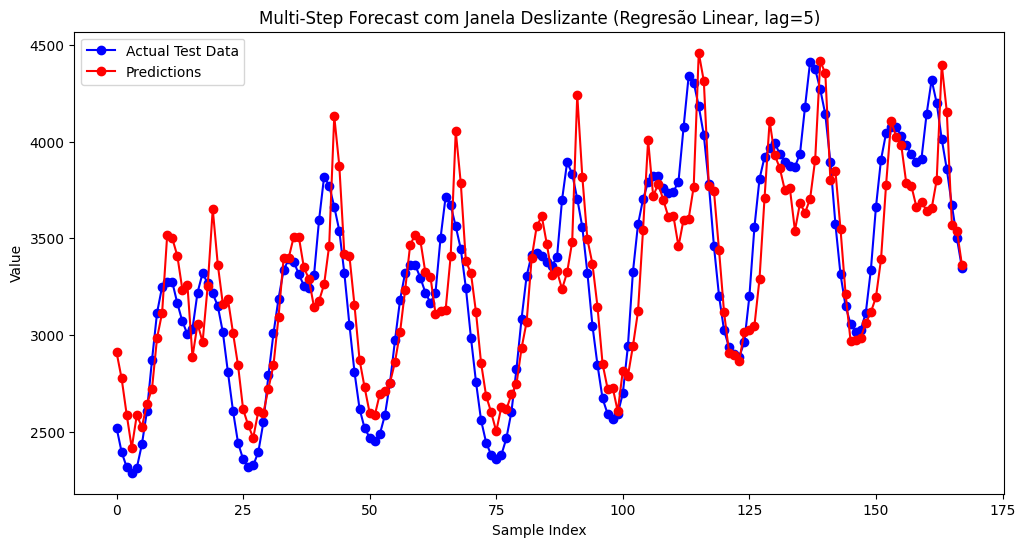

In [79]:
model_lr_multi = LinearRegression()
model_lr_multi.fit(X_train, y_train)

predictions_multi_lr = model_lr_multi.predict(X_test)
mse_multi_lr = mean_squared_error(y_test, predictions_multi_lr)
print(f'Mean Squared Error (Multi Step - Regressão Linear): {mse_multi_lr}')
mae_lr_multi = mean_absolute_error(y_test, predictions_multi_lr)
mse_lr_multi = mean_squared_error(y_test, predictions_multi_lr)
rmse_lr_multi = mean_squared_error(y_test, predictions_multi_lr, squared=False) 

print(f'Mean Absolute Error (MAE) - Linear Regression: {mae_lr_multi}')
print(f'Mean Squared Error (MSE) - Linear Regression: {mse_lr_multi}')
print(f'Root Mean Squared Error (RMSE) - Linear Regression: {rmse_lr_multi}')

#ploting linear regresison
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o', color= 'blue' )
plt.plot(predictions_multi_lr[last_week:], label='Predictions',  marker='o',color= 'red')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Regresão Linear, lag=5)')
plt.legend()
plt.show()



Mean Squared Error (Multi-Step - XGBoost): 38589.60193848476
Mean Absolute Error (MAE) - Linear Regression: 130.33560330521982
Mean Squared Error (MSE) - Linear Regression: 38589.60193848476
Root Mean Squared Error (RMSE) - Linear Regression: 196.4423628917265


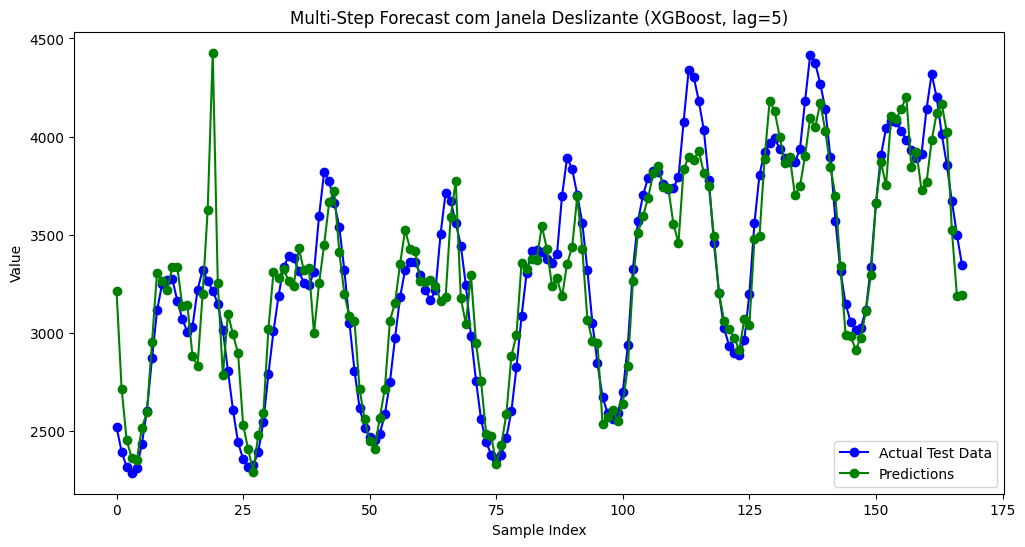

In [80]:
model_xgb_multi = XGBRegressor()

model_xgb_multi.fit(X_train, y_train)

predictions_multi_xgb = model_xgb_multi.predict(X_test)


mse_multi_step_xgb = mean_squared_error(y_test, predictions_multi_xgb)
print(f"Mean Squared Error (Multi-Step - XGBoost): {mse_multi_step_xgb}")

mae_xgb_multi = mean_absolute_error(y_test, predictions_multi_xgb)
mse_xgb_multi = mean_squared_error(y_test, predictions_multi_xgb)
rmse_xgb_multi = mean_squared_error(y_test, predictions_multi_xgb, squared=False) 

print(f'Mean Absolute Error (MAE) - XGBoost: {mae_xgb_multi}')
print(f'Mean Squared Error (MSE) - XGBoost: {mse_xgb_multi}')
print(f'Root Mean Squared Error (RMSE) - XGBoost: {rmse_xgb_multi}')
#ploting xgb
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o',color= 'blue' )
plt.plot(predictions_multi_xgb[last_week:], label='Predictions',  marker='o', color= 'green')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (XGBoost, lag=5)')
plt.legend()
plt.show()



Mean Squared Error (Multi-Step - Gradient Boosting): 38589.60193848476
Mean Absolute Error (MAE) - Gradient Boost: 130.33560330521982
Mean Squared Error (MSE) - Gradient Boost: 38589.60193848476
Root Mean Squared Error (RMSE) - Gradient Boost: 196.4423628917265


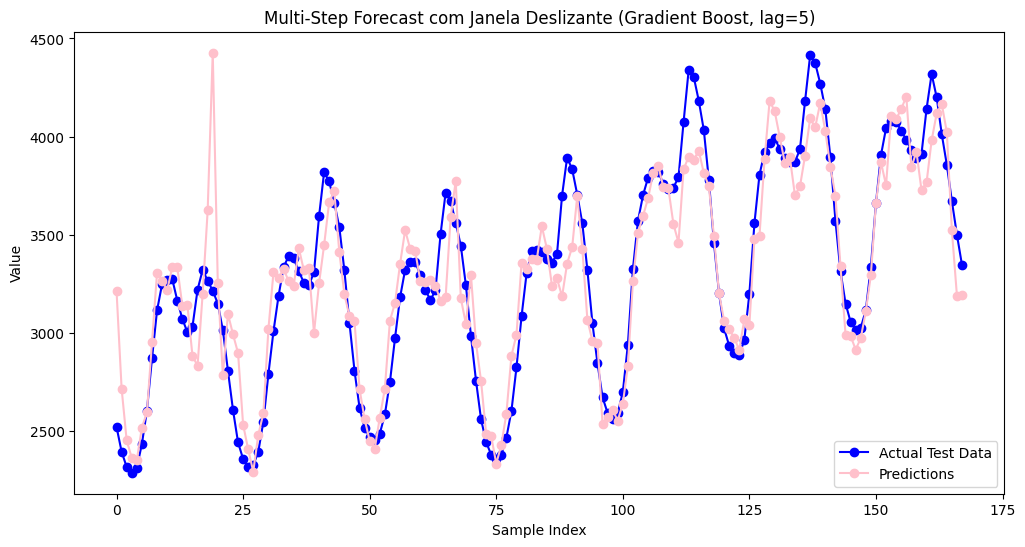

In [92]:


model_gboost = GradientBoostingRegressor()
model_gboost.fit(X_train, y_train)

predictions_multi_gboost = model_xgb_multi.predict(X_test)


mse_multi_step_gboost = mean_squared_error(y_test, predictions_multi_gboost)
print(f"Mean Squared Error (Multi-Step - Gradient Boosting): {mse_multi_step_gboost}")

mae_gboost_multi = mean_absolute_error(y_test, predictions_multi_gboost)
mse_gboost_multi = mean_squared_error(y_test, predictions_multi_gboost)
rmse_gboost_multi = mean_squared_error(y_test, predictions_multi_gboost, squared=False) 

print(f'Mean Absolute Error (MAE) - Gradient Boost: {mae_gboost_multi}')
print(f'Mean Squared Error (MSE) - Gradient Boost: {mse_gboost_multi}')
print(f'Root Mean Squared Error (RMSE) - Gradient Boost: {rmse_gboost_multi}')
#ploting GB
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o',color= 'blue' )
plt.plot(predictions_multi_gboost[last_week:], label='Predictions',  marker='o',color= 'pink')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Gradient Boost, lag=5)')
plt.legend()
plt.show()

Mean Squared Error (Multi-Step - Random Forest): 35361.459724790635
Mean Absolute Error (MAE) - Linear Regression: 119.25278264179673
Mean Squared Error (MSE) - Linear Regression: 35361.459724790635
Root Mean Squared Error (RMSE) - Linear Regression: 188.04642970498173


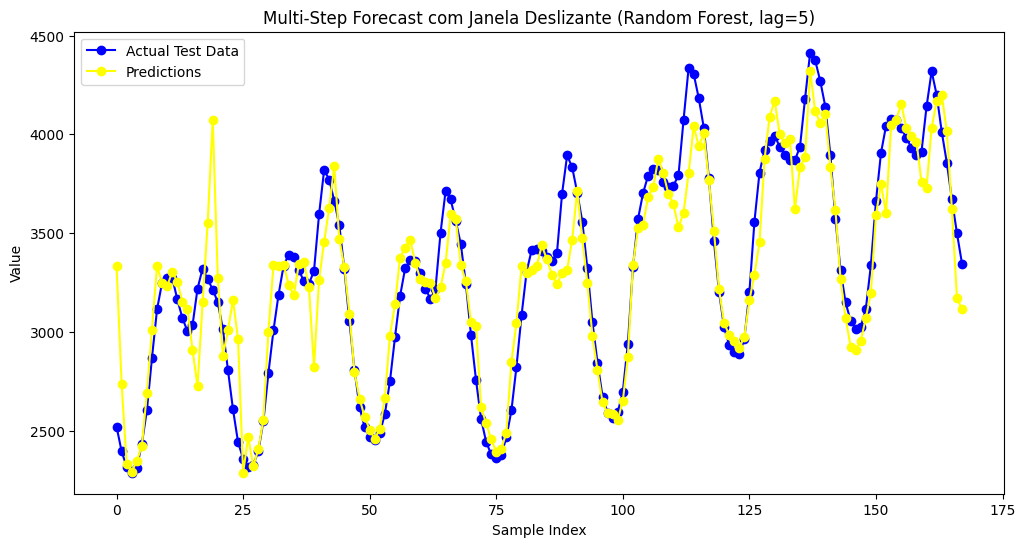

In [81]:

model_rf_multi = RandomForestRegressor()
model_rf_multi.fit(X_train, y_train)

predictions_multi_step_rf = model_rf_multi.predict(X_test)


mse_multi_step_rf = mean_squared_error(y_test, predictions_multi_step_rf)
print(f"Mean Squared Error (Multi-Step - Random Forest): {mse_multi_step_rf}")

mae_rf_multi = mean_absolute_error(y_test, predictions_multi_step_rf)
mse_rf_multi = mean_squared_error(y_test, predictions_multi_step_rf)
rmse_rf_multi = mean_squared_error(y_test, predictions_multi_step_rf, squared=False) 

print(f'Mean Absolute Error (MAE) - Random Forest: {mae_rf_multi}')
print(f'Mean Squared Error (MSE) - Random Forest: {mse_rf_multi}')
print(f'Root Mean Squared Error (RMSE) - Random Forest: {rmse_rf_multi}')

#ploting GB
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o',color= 'blue' )
plt.plot(predictions_multi_step_rf[last_week:], label='Predictions',  marker='o',color= 'yellow')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Random Forest, lag=5)')
plt.legend()
plt.show()


Epoch 1/50
527/527 [==============================] - 3s 3ms/step - loss: 475612.1562 - val_loss: 189963.9062
Epoch 2/50
527/527 [==============================] - 2s 3ms/step - loss: 177822.0781 - val_loss: 146126.6094
Epoch 3/50
527/527 [==============================] - 1s 2ms/step - loss: 142972.0938 - val_loss: 125910.4922
Epoch 4/50
527/527 [==============================] - 1s 2ms/step - loss: 129278.6172 - val_loss: 117735.2578
Epoch 5/50
527/527 [==============================] - 1s 2ms/step - loss: 122642.5391 - val_loss: 115758.6953
Epoch 6/50
527/527 [==============================] - 2s 3ms/step - loss: 120455.4297 - val_loss: 115016.5469
Epoch 7/50
527/527 [==============================] - 2s 4ms/step - loss: 113828.4844 - val_loss: 134221.8750
Epoch 8/50
527/527 [==============================] - 2s 4ms/step - loss: 113218.3281 - val_loss: 100749.5859
Epoch 9/50
527/527 [==============================] - 2s 5ms/step - loss: 109967.7344 - val_loss: 111593.5859
Epoch 10/5

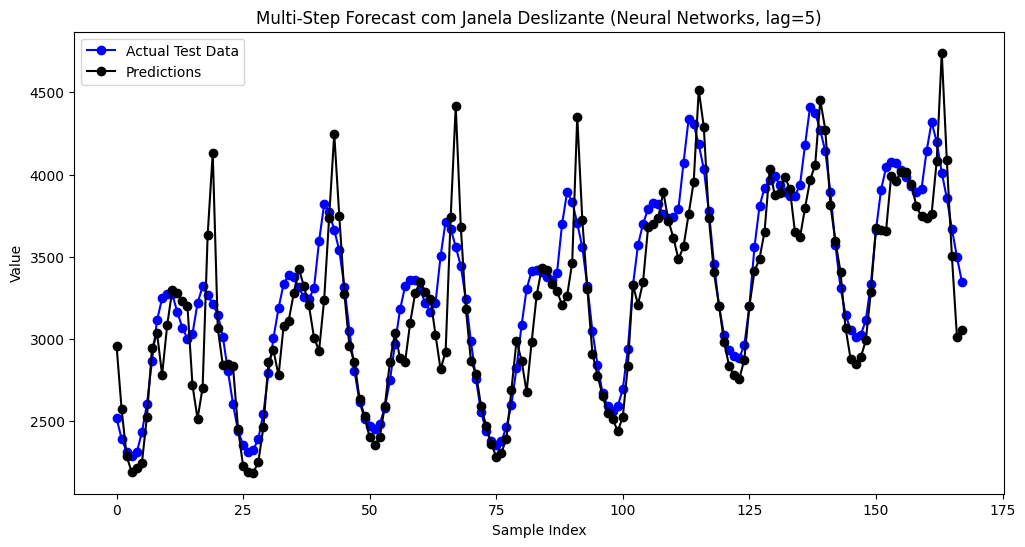

In [82]:


model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred_multi_NN = model.predict(X_test).flatten()

mse_multi_NN = mean_squared_error(y_test, y_pred_multi_NN)
print(f'Mean Squared Error on Multi Step Neural Network: {mse_multi_NN}')

mae_nn_multi = mean_absolute_error(y_test, y_pred_multi_NN)
mse_nn_multi = mean_squared_error(y_test, y_pred_multi_NN)
rmse_nn_multi = mean_squared_error(y_test, y_pred_multi_NN, squared=False) 

print(f'Mean Absolute Error (MAE) - Redes Neuronais: {mae_nn_multi}')
print(f'Mean Squared Error (MSE) - Redes Neuronais: {mse_nn_multi}')
print(f'Root Mean Squared Error (RMSE) - Redes Neuronais: {rmse_nn_multi}')
#ploting NN
last_week = -168

plt.figure(figsize=(12, 6))
plt.plot(y_test[last_week:], label='Actual Test Data', marker='o',color= 'blue' )
plt.plot(y_pred_multi_NN[last_week:], label='Predictions',  marker='o',color= 'black')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Multi-Step Forecast com Janela Deslizante (Neural Networks, lag=5)')
plt.legend()
plt.show()


# Deep Learning

In [104]:
from sklearn.feature_selection import SequentialFeatureSelector


def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]

        X.append(row)
        label = df_as_np[i+5]

        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_X_y(df['load'], 5)
X, y = df_to_X_y(df['load'], 6)

split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

X_train, y_train = X[:split_train_index], y[:split_train_index]
X_val, y_val = X[split_train_index:split_val_index], y[split_train_index:split_val_index]
X_test, y_test = X[split_val_index:], y[split_val_index:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=50, batch_size=32, verbose=1)

predictions_single_lstm = model_lstm.predict(X_test)

mse_single_lstm = mean_squared_error(y_test, predictions_single_lstm)
mae_lstm_single = mean_absolute_error(y_test, predictions_single_lstm)
mse_lstm_single = mean_squared_error(y_test, predictions_single_lstm)
rmse_lstm_single = mean_squared_error(y_test, predictions_single_lstm, squared=False) 

print(f'Mean Absolute Error (MAE) - LSTM single: {mae_lstm_single}')
print(f'Mean Squared Error (MSE) - LSTM single: {mse_lstm_single}')
print(f'Root Mean Squared Error (RMSE) - LSTM single: {rmse_lstm_single}')



def df_to_X_y_multi(df, window_size, horizon):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        row = [[a] for a in df_as_np[i:i+window_size]]

        X.append(row)
        labels = df_as_np[i+window_size:i+window_size+horizon]

        y.append(labels)
    return np.array(X), np.array(y)

X_multi, y_multi = df_to_X_y_multi(df['load'], window_size=5, horizon=3)

split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

X_train_multi, y_train_multi = X_multi[:split_train_index], y_multi[:split_train_index]
X_val_multi, y_val_multi = X_multi[split_train_index:split_val_index], y_multi[split_train_index:split_val_index]
X_test_multi, y_test_multi = X_multi[split_val_index:], y_multi[split_val_index:]

print(X_train_multi.shape, y_train_multi.shape)
print(X_val_multi.shape, y_val_multi.shape)
print(X_test_multi.shape, y_test_multi.shape)

model_lstm_multi = Sequential()
model_lstm_multi.add(LSTM(50, activation='relu', input_shape=(X_train_multi.shape[1], 1)))
model_lstm_multi.add(Dense(3))  # Assuming horizon=3
model_lstm_multi.compile(optimizer='adam', loss='mse')

model_lstm_multi.fit(X_train_multi, y_train_multi, validation_data=(X_val_multi, y_val_multi), epochs=50, batch_size=32, verbose=1)

predictions_multi_lstm = model_lstm_multi.predict(X_test_multi)

mse_multi_lstm = mean_squared_error(y_test_multi.reshape(-1, 1), predictions_multi_lstm.reshape(-1, 1))
mae_lstm_multi = mean_absolute_error(y_test_multi, predictions_multi_lstm)
mse_lstm_multi = mean_squared_error(y_test_multi, predictions_multi_lstm)
rmse_lstm_multi = mean_squared_error(y_test_multi, predictions_multi_lstm, squared=False) 

print(f'Mean Absolute Error (MAE) - LSTM Multi: {mae_lstm_multi}')
print(f'Mean Squared Error (MSE) - LSTM Multi: {mse_lstm_multi}')
print(f'Root Mean Squared Error (RMSE) - LSTM Multi: {rmse_lstm_multi}')



(18413, 5, 1) (18413,)
(2631, 5, 1) (2631,)
(5255, 5, 1) (5255,)
Epoch 1/50
576/576 [==============================] - 3s 3ms/step - loss: 406698.2500 - val_loss: 45934.5938
Epoch 2/50
576/576 [==============================] - 2s 3ms/step - loss: 49531.4648 - val_loss: 33274.2070
Epoch 3/50
576/576 [==============================] - 2s 3ms/step - loss: 42436.8242 - val_loss: 34291.8906
Epoch 4/50
576/576 [==============================] - 2s 4ms/step - loss: 48888.6758 - val_loss: 54223.5664
Epoch 5/50
576/576 [==============================] - 2s 4ms/step - loss: 61439.9727 - val_loss: 34661.3750
Epoch 6/50
576/576 [==============================] - 2s 3ms/step - loss: 39345.0000 - val_loss: 37955.1758
Epoch 7/50
576/576 [==============================] - 2s 3ms/step - loss: 35738.4297 - val_loss: 31967.2305
Epoch 8/50
576/576 [==============================] - 2s 3ms/step - loss: 33371.7422 - val_loss: 28789.9082
Epoch 9/50
576/576 [==============================] - 2s 3ms/step - lo

In [105]:
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)
predictions_single_gru = model_gru.predict(X_test)
mse_single_gru = mean_squared_error(y_test, predictions_single_gru)

mae_lstm_multi = mean_absolute_error(y_test, predictions_single_gru)
mse_lstm_multi = mean_squared_error(y_test, predictions_single_gru)
rmse_lstm_multi = mean_squared_error(y_test, predictions_single_gru, squared=False) 

print(f'Mean Absolute Error (MAE) - LSTM Multi: {mae_lstm_multi}')
print(f'Mean Squared Error (MSE) - LSTM Multi: {mse_lstm_multi}')
print(f'Root Mean Squared Error (RMSE) - LSTM Multi: {rmse_lstm_multi}')

def df_to_X_y_multi(df, window_size, horizon):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np) - window_size - horizon + 1):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        
        labels = df_as_np[i+window_size:i+window_size+horizon]
        y.append(labels)
    
    return np.array(X), np.array(y)

# Modificar a chamada da função para incluir o tamanho da janela e o horizonte desejados
X, y_multi = df_to_X_y_multi(df['load'], window_size=5, horizon=3)

# Divisão em treino, validação e teste
split_train_ratio = 0.7
split_train_index = int(split_train_ratio * len(df))

split_val_ratio = 0.8
split_val_index = int(split_val_ratio * len(df))

X_train_multi, y_train_multi = X_multi[:split_train_index], y_multi[:split_train_index]
X_val_multi, y_val_multi = X_multi[split_train_index:split_val_index], y_multi[split_train_index:split_val_index]
X_test_multi, y_test_multi = X_multi[split_val_index:], y_multi[split_val_index:]

print(X_train_multi.shape, y_train_multi.shape)
print(X_val_multi.shape, y_val_multi.shape)
print(X_test_multi.shape, y_test_multi.shape)

# Construir o modelo GRU para previsão de vários passos
model_gru_multi = Sequential()
model_gru_multi.add(GRU(50, activation='relu', input_shape=(X_train_multi.shape[1], 1)))
model_gru_multi.add(Dense(3))  # Supondo horizon=3
model_gru_multi.compile(optimizer='adam', loss='mse')

# Treinar o modelo GRU para previsão de vários passos
model_gru_multi.fit(X_train_multi, y_train_multi, validation_data=(X_val_multi, y_val_multi), epochs=50, batch_size=32, verbose=1)

# Previsão de vários passos
predictions_multi_gru = model_gru_multi.predict(X_test_multi)

mse_multi_gru = mean_squared_error(y_test_multi.reshape(-1, 1), predictions_multi_gru.reshape(-1, 1))
mae_gru_multi = mean_absolute_error(y_test_multi, predictions_multi_gru)
mse_gru_multi = mean_squared_error(y_test_multi, predictions_multi_gru)
rmse_gru_multi = mean_squared_error(y_test_multi, predictions_multi_gru, squared=False) 

print(f'Mean Absolute Error (MAE) - gru Multi: {mae_gru_multi}')
print(f'Mean Squared Error (MSE) - gru Multi: {mse_gru_multi}')
print(f'Root Mean Squared Error (RMSE) - gru Multi: {rmse_gru_multi}')



Epoch 1/50
576/576 [==============================] - 4s 4ms/step - loss: 1751157.0000 - val_loss: 63500.6016
Epoch 2/50
576/576 [==============================] - 3s 5ms/step - loss: 65673.5391 - val_loss: 43585.3594
Epoch 3/50
576/576 [==============================] - 2s 4ms/step - loss: 44156.9570 - val_loss: 36424.9922
Epoch 4/50
576/576 [==============================] - 3s 5ms/step - loss: 37042.5430 - val_loss: 31222.1113
Epoch 5/50
576/576 [==============================] - 3s 5ms/step - loss: 32409.6660 - val_loss: 27465.2988
Epoch 6/50
576/576 [==============================] - 3s 5ms/step - loss: 27918.4785 - val_loss: 23160.5195
Epoch 7/50
576/576 [==============================] - 3s 5ms/step - loss: 23708.9844 - val_loss: 19197.1074
Epoch 8/50
576/576 [==============================] - 3s 5ms/step - loss: 19361.3164 - val_loss: 17142.2949
Epoch 9/50
576/576 [==============================] - 3s 5ms/step - loss: 15623.4814 - val_loss: 12354.9082
Epoch 10/50
576/576 [=====

In [97]:
df_last_week = df.tail(7 * 24)  # 7 dias * 24 horas por dia
historical_means_by_hour = df_last_week.groupby(df_last_week.index.hour)['load'].mean()
predictions_baseline_by_hour = historical_means_by_hour[df_last_week.index.hour].values
mse_baseline_by_hour = mean_squared_error(df_last_week['load'], predictions_baseline_by_hour)

print(f'Mean Squared Error (Baseline por Hora - Última Semana): {mse_baseline_by_hour}')

mae_baseline = mean_absolute_error(df_last_week['load'], predictions_baseline_by_hour)
mse_baseline = mean_squared_error(df_last_week['load'], predictions_baseline_by_hour)
rmse_baseline = mean_squared_error(df_last_week['load'], predictions_baseline_by_hour, squared=False) 

print(f'Mean Absolute Error (MAE) - baseline: {mae_baseline}')
print(f'Mean Squared Error (MSE) - baseline: {mse_baseline}')
print(f'Root Mean Squared Error (RMSE) - baseline: {rmse_baseline}')


Mean Squared Error (Baseline por Hora - Última Semana): 106054.83673469388
Mean Absolute Error (MAE) - baseline: 296.03231292517006
Mean Squared Error (MSE) - baseline: 106054.83673469388
Root Mean Squared Error (RMSE) - baseline: 325.66061587900657


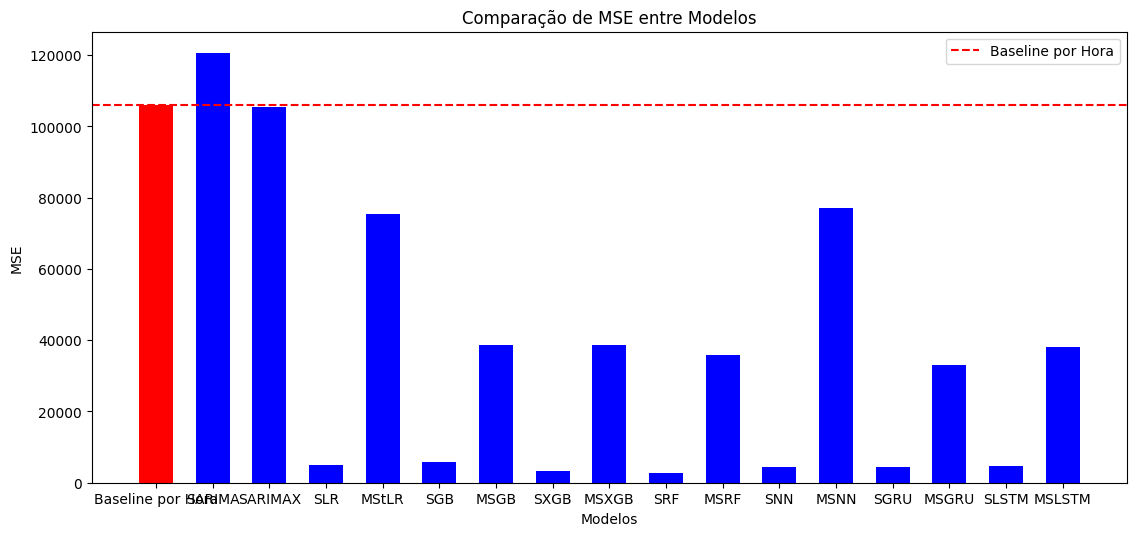

In [69]:
plt.figure(figsize=(12, 6))

# Adicionar barras para os valores de MSE
plt.bar(
["Baseline por Hora","SARIMA","SARIMAX", "SLR", "MStLR", "SGB", "MSGB", "SXGB", "MSXGB", "SRF", "MSRF", "SNN", "MSNN", "SGRU", "MSGRU", "SLSTM", "MSLSTM"],
    [
        mse_baseline_by_hour,
        mse_sarima,
        mse_sarimaX,
        mse_single_lr,
        mse_multi_lr,
        mse_single_gboost,
        mse_multi_step_gboost,
        mse_single_xgb,
        mse_multi_step_xgb,
        mse_single_rf,
        mse_multi_step_rf,
        mse_single_nn,
        mse_multi_NN,
        mse_single_gru,
        mse_gru_multi,
        mse_single_lstm,
        mse_multi_lstm,
    ],
    color=["red"] + ["blue"] * 16,
    width=0.6  # Ajuste o valor conforme necessário
)

# Adicionar uma linha horizontal tracejada para o valor do primeiro modelo (Baseline por Hora)
plt.axhline(
    y=mse_baseline_by_hour, color="red", linestyle="--", label="Baseline por Hora"
)

# Configurar título e rótulos dos eixos
plt.title("Comparação de MSE entre Modelos")
plt.xlabel("Modelos")
plt.ylabel("MSE")

# Adicionar legenda
plt.legend()

# Ajustar layout para aumentar o espaço entre as barras e as legendas
plt.tight_layout(pad=3.0)  # Ajuste o valor de 'pad' conforme necessário

# Mostrar o gráfico
plt.show()


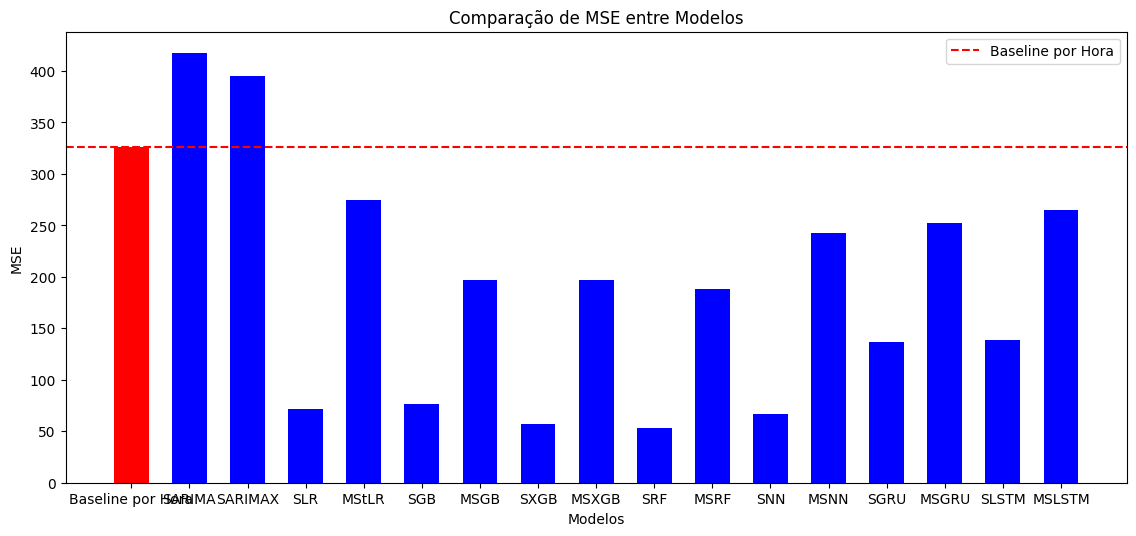

In [103]:
plt.figure(figsize=(12, 6))

plt.bar(
["Baseline por Hora","SARIMA","SARIMAX", "SLR", "MStLR", "SGB", "MSGB", "SXGB", "MSXGB", "SRF", "MSRF", "SNN", "MSNN", "SGRU", "MSGRU", "SLSTM", "MSLSTM"],
    [
        rmse_baseline,
        rmse_sarima,
        rmse_sarimaX,
        rmse_lr_single,
        rmse_lr_multi,
        rmse_gboost_single,
        rmse_gboost_multi,
        rmse_xgb_single,
        rmse_xgb_multi,
        rmse_rf_single,
        rmse_rf_multi,
        rmse_nn_single,
        rmse_nn_multi,
        rmse_gru_single,
        rmse_gru_multi,
        rmse_lstm_single,
        rmse_lstm_multi,
    ],
    color=["red"] + ["blue"] * 16,
    width=0.6  
)

plt.axhline(
    y=mse_baseline_by_hour, color="red", linestyle="--", label="Baseline por Hora"
)

plt.title("Comparação de MSE entre Modelos")
plt.xlabel("Modelos")
plt.ylabel("MSE")

plt.legend()

plt.tight_layout(pad=3.0)  

plt.show()


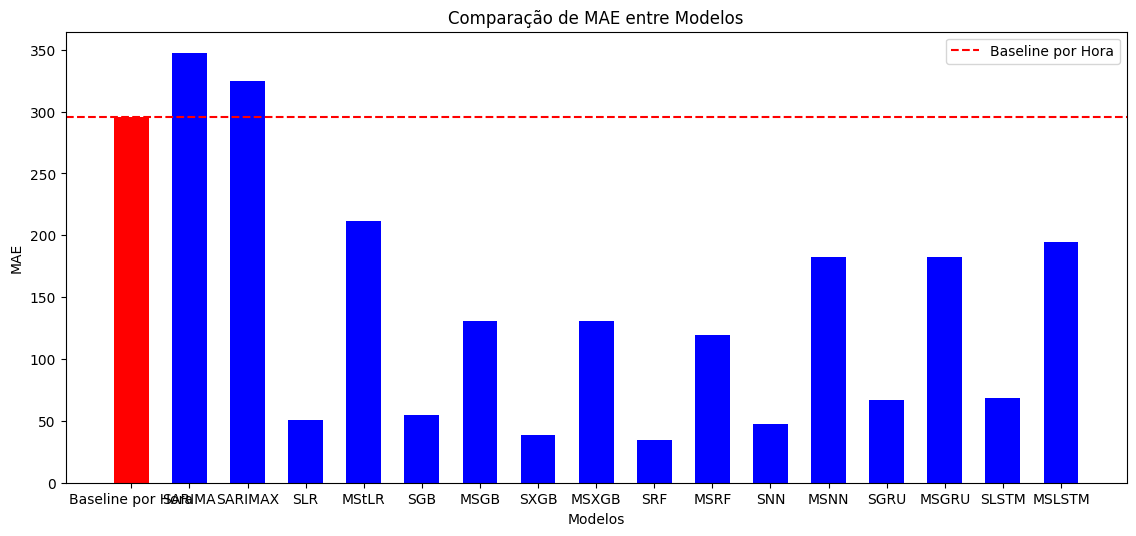

In [99]:
plt.figure(figsize=(12, 6))

plt.bar(
["Baseline por Hora","SARIMA","SARIMAX", "SLR", "MStLR", "SGB", "MSGB", "SXGB", "MSXGB", "SRF", "MSRF", "SNN", "MSNN", "SGRU", "MSGRU", "SLSTM", "MSLSTM"],
    [
        mae_baseline,
        mae_sarima,
        mae_sarimaX,
        mae_lr_single,
        mae_lr_multi,
        mae_gboost_single,
        mae_gboost_multi,
        mae_xgb_single,
        mae_xgb_multi,
        mae_rf_single,
        mae_rf_multi,
        mae_nn_single,
        mae_nn_multi,
        mae_gru_single,
        mae_gru_multi,
        mae_lstm_single,
        mae_gru_multi,
    ],
    color=["red"] + ["blue"] * 16,
    width=0.6  # Ajuste o valor conforme necessário
)

# Adicionar uma linha horizontal tracejada para o valor do primeiro modelo (Baseline por Hora)
plt.axhline(
    y=mae_baseline, color="red", linestyle="--", label="Baseline por Hora"
)

# Configurar título e rótulos dos eixos
plt.title("Comparação de MAE entre Modelos")
plt.xlabel("Modelos")
plt.ylabel("MAE")

# Adicionar legenda
plt.legend()

# Ajustar layout para aumentar o espaço entre as barras e as legendas
plt.tight_layout(pad=3.0)  # Ajuste o valor de 'pad' conforme necessário

# Mostrar o gráfico
plt.show()
